In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define the path to your dataset directory (it should have 5 folders as described)
data_dir = os.path.join(os.getcwd(), 'combined_dataset')

# Parameters for image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and rescaling with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ----- Build the Model using DenseNet121 -----
# Load DenseNet121 as the base model (pre-trained on ImageNet) without the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom top layers on DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)      # Reduces spatial dimensions
x = BatchNormalization()(x)          # Helps with training stability
x = Dense(128, activation='relu')(x)   # Fully-connected layer
x = Dropout(0.5)(x)                  # Regularization with dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Final softmax classifier

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the DenseNet121 base layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (use a standard learning rate for initial training)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ----- Define Callbacks -----
# Save the best model based on validation accuracy during training
checkpoint_initial = ModelCheckpoint(
    'densenet_initial_best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# ----- Training Phase 1: Initial Training -----
epochs_initial = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs_initial,
    callbacks=[checkpoint_initial, lr_scheduler, early_stopping]
)

# Save the best initial model is automatically handled by the checkpoint callback.
# (Optionally, you can also save the last epoch's model for reference)
# model.save('densenet_initial_trained_model.keras')

# ----- Training Phase 2: Fine-Tuning -----
# Unfreeze the last 30 layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define a checkpoint for fine-tuning (save the best fine-tuned model)
checkpoint_finetune = ModelCheckpoint(
    'densenet_trained_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_finetune, lr_scheduler, early_stopping]
)

# The best fine-tuned model is saved as 'densenet_trained_model.keras'
print("Training complete and best fine-tuned model saved as 'densenet_trained_model.keras'")


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8755 - loss: 0.3375

C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.97480, saving model to densenet_initial_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2674s 4s/step - accuracy: 0.8755 - loss: 0.3373 - val_accuracy: 0.9748 - val_loss: 0.0678 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9600 - loss: 0.1048
Epoch 2: val_accuracy improved from 0.97480 to 0.97500, saving model to densenet_initial_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2602s 4s/step - accuracy: 0.9600 - loss: 0.1048 - val_accuracy: 0.9750 - val_loss: 0.0582 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9630 - loss: 0.0981
Epoch 3: val_accuracy improved from 0.97500 to 0.98340, saving model to densenet_initial_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2512s 4s/step - accuracy: 0.9630 - loss: 0.0980 - val_accuracy: 0.9834 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9690 - loss: 0.0808


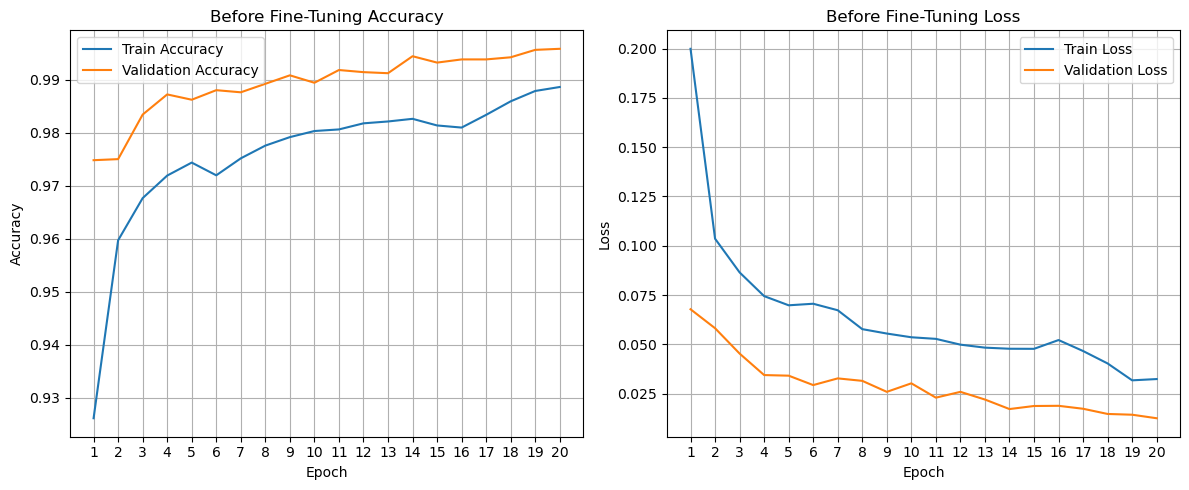

157/157 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step


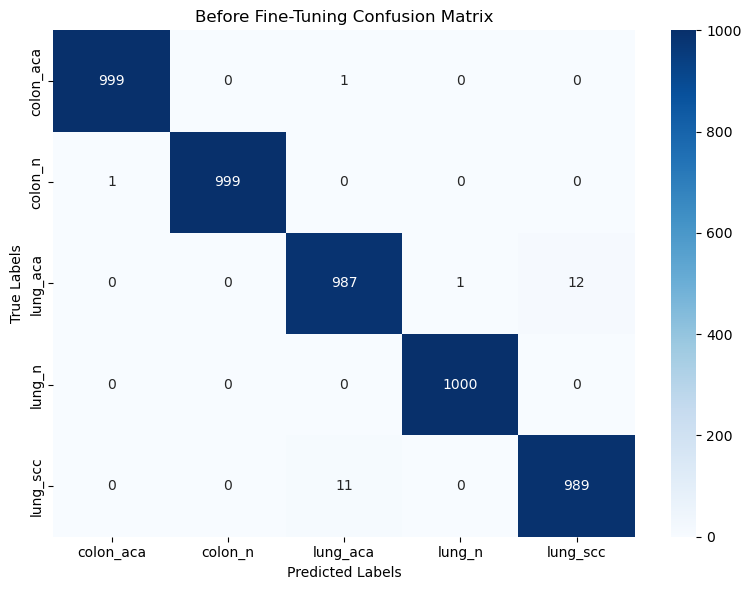


Before Fine-Tuning Classification Report:

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1000
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.99      0.99      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.99      0.99      0.99      1000

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



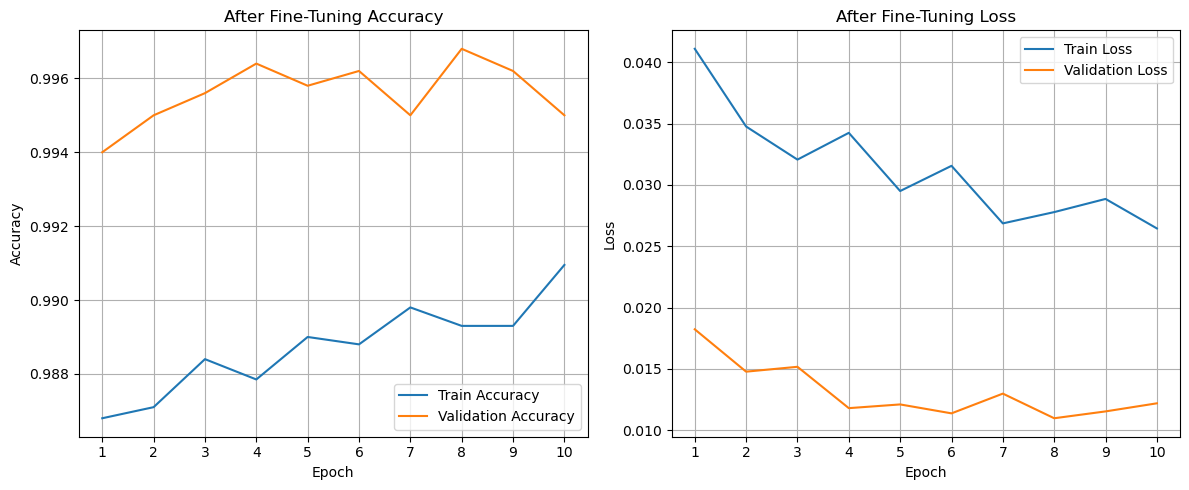

157/157 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step


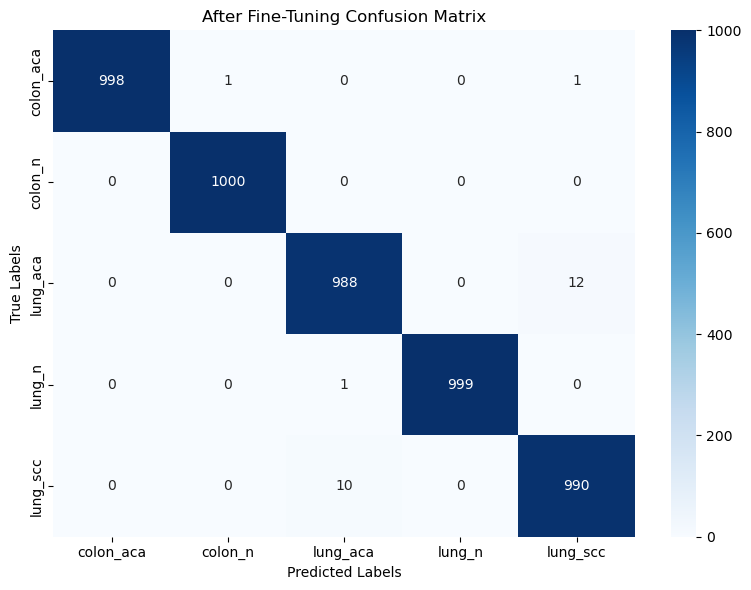


After Fine-Tuning Classification Report:

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1000
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.99      0.99      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.99      0.99      0.99      1000

    accuracy                           0.99      5000
   macro avg       1.00      0.99      1.00      5000
weighted avg       1.00      0.99      1.00      5000



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# ------- Plot Accuracy and Loss -------
def plot_metrics(history, title_prefix=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(1, len(acc) + 1))  # Use integer epoch numbers

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ------- Confusion Matrix & Classification Report -------
def plot_confusion_matrix_and_report(model, generator, title_prefix=''):
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\n{title_prefix} Classification Report:\n")
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)

# ===============================
# ✅ LOADING TRAINED MODELS
# ===============================

# Load best models (saved during training)
model_before_finetuning = load_model('densenet_initial_best_model.keras')
model_after_finetuning = load_model('densenet_trained_model.keras')

# ===============================
# ✅ PLOTTING RESULTS
# ===============================

# Plot training history (replace `history` and `history_fine` with your actual variables if available)
plot_metrics(history, title_prefix='Before Fine-Tuning')
plot_confusion_matrix_and_report(model_before_finetuning, validation_generator, title_prefix='Before Fine-Tuning')

plot_metrics(history_fine, title_prefix='After Fine-Tuning')
plot_confusion_matrix_and_report(model_after_finetuning, validation_generator, title_prefix='After Fine-Tuning')
